# Multi-label classification

In this notebook we will consider three classes of patients:
* Healthy: Label 0
* Mild Heart Failure: Label 1
* Severe Heart Failure: Label 2

The data is otherwise similar to the previous notebook. We will consider the same two features - **EF** and **GLS**.

### Libraries and dataset
Run the code below to load the libraries, dataset, create the feature matrix `X` and label vector `y` and finally plot the dataset.

In [1]:
# Imports needed for this notebook
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

In [2]:
# This code will download the required data files from GitHub
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

In [3]:
# Download the data
download_data('Week-3-Classification-models/data/heart_failure_data_complete.csv', 'temp/heart_failure_data_complete.csv')

# Read data file into a dataframe object
df = pd.read_csv('temp/heart_failure_data_complete.csv')

# Print the first few lines of the dataframe
df.head()

,HF,EF,GLS,QRS
0,0,50.922280,-19.57,88
1,0,54.601227,-19.00,86
2,0,50.000000,-21.00,99
3,0,50.819672,-18.74,85
4,0,53.191489,-19.78,86


## Data dictionary

**HF**: Heart Failure class
- 0 = Healthy
- 1 = Mild HF (heart failure)
- 2 = Severe HF (heart failure)

**EF**: Ejection Fraction. A measurement of how much blood the left ventricle pumps out with each contraction. Expressed as a percent in the range 0 to 100.

**GLS**: Global Longitudinal Strain. A measure ment of myocardial deformation along the longitudinal cardiac axis. Expressed as a negative percent in the range 0 to -100.

**QRS**: QRS interval (milliseconds)GLS. (This column will not be used for this notebook.)

### Exploratory Data Analysis

In [4]:
# Check balance of the output variables
df.groupby(['HF'])['HF'].count()

HF
0    60
1    48
2    12
Name: HF, dtype: int64

Note that the classes are extremely unbalanced.

In [5]:
# Convert dataframe to numpy array
heart_failure_data = df.to_numpy()

# Create feature matrix with EF and GLS
# We'll ignore the QRS data for this example
X = heart_failure_data[:,[1,2]]

# Create label vector 
y = heart_failure_data[:,0]

# print properties
print('Feature matrix X dimensions: ', X.shape)
print('Target vector y dimensions: ', y.shape)
print('Labels: ', np.unique(y))

Feature matrix X dimensions:  (120, 2)
Target vector y dimensions:  (120,)
Labels:  [0. 1. 2.]


Note that we updated the function `PlotData` to deal with 3 classes.

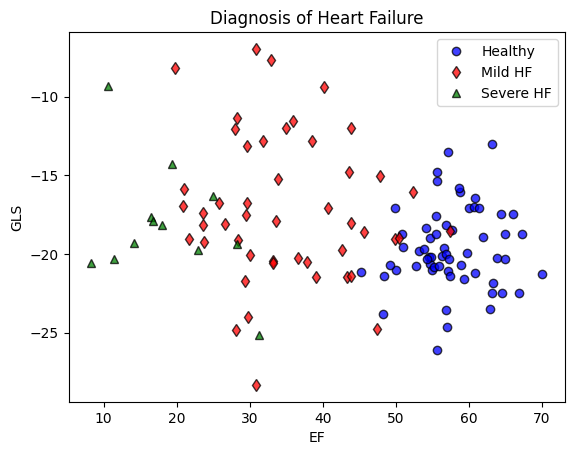

In [6]:
def PlotData(X,y):
    
    # Plot class 0
    plt.plot(X[y==0,0], X[y==0,1], 'bo', alpha=0.75, markeredgecolor='k', label = 'Healthy')

    # Plot class 1
    plt.plot(X[y==1,0], X[y==1,1], 'rd', alpha=0.75, markeredgecolor='k', label = 'Mild HF')

    # Plot class 2
    plt.plot(X[y==2,0], X[y==2,1], 'g^', alpha=0.75,markeredgecolor='k',label = 'Severe HF')
    
    # Annotate the plot
    plt.title('Diagnosis of Heart Failure')
    plt.xlabel('EF')
    plt.ylabel('GLS')
    plt.legend()

# Call the function to plot the dataset
PlotData(X,y)

## Standardize Data

We'll use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardize the data.

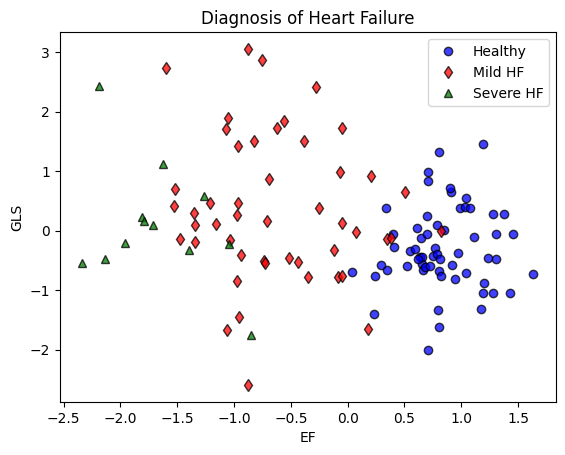

In [7]:
# Create an object to scale the features to have zero mean and unit variance
# We don't need to do this for all models, but let's do it here to be consistent
scaler = StandardScaler()

# Create a feature matrix containing EF and GLS
X = scaler.fit_transform(X)

# Plot the scaled data
PlotData(X, y)

## Creating training and test sets

We'll create training and test sets as in the previous example.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Using a fixed random_state for consistency

### Functions
The cell below contains some of the functions that we have created in the previous notebook and which have been modified for multilabel classification. These functions are
* `PlotDecisionBoundary`
* `PlotConfidenceScores`
* `PlotProbabilities`
* `PlotSVCDecisionBoundary`
* `EvaluateModel`

Run the cell.

In [9]:
def PlotProbabilities(model, X, y, label=1):

    # Create an 1D array of samples for each feature
    x1 = np.linspace(-2.5, 2, 1000) 
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 

    # Predict labels for the whole feature space
    # Note the predict_proba function! This gives us the probabilities
    proba = model.predict_proba(Feature_space)
    
    # Select the class
    p = proba[:, label]
    
    # Reshape to 2D
    p = p.reshape(x1.shape)
    
    # Plot using contourf
    plt.contourf(x1, x2, p, cmap = 'summer')
    
    # Add colorbar
    plt.colorbar()
    
    # Plot data
    PlotData(X, y)

def EvaluateModel(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True)
    plt.gcf().set_size_inches(2, 2)
    plt.show()
    print('Classification report for training set:')
    print(classification_report(y_train, y_train_pred, zero_division=0.0))
    print('Classfication report for test set:')
    print(classification_report(y_test, y_test_pred, zero_division=0.0))


### Perceptron



In [10]:
#p_model = Perceptron(max_iter=100, eta0=0.2)
#p_model.fit(X_train, y_train)
#EvaluateModel(p_model, X_train, X_test, y_train, y_test)
#PlotConfidenceScores(model, X, y, label=1)

### Logistic Regression



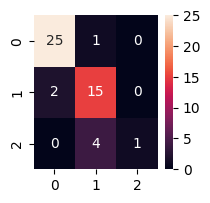

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        34
         1.0       0.85      0.90      0.88        31
         2.0       1.00      0.29      0.44         7

    accuracy                           0.89        72
   macro avg       0.92      0.73      0.76        72
weighted avg       0.90      0.89      0.87        72

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94        26
         1.0       0.75      0.88      0.81        17
         2.0       1.00      0.20      0.33         5

    accuracy                           0.85        48
   macro avg       0.89      0.68      0.70        48
weighted avg       0.87      0.85      0.83        48



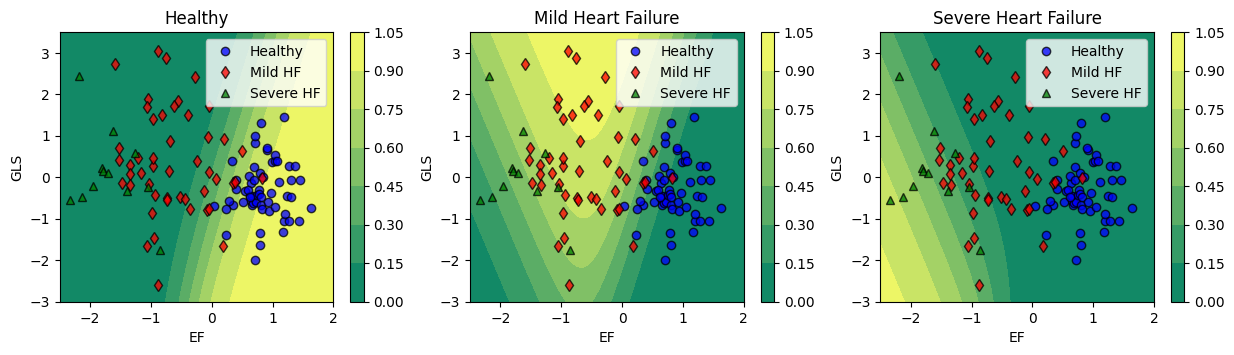

In [11]:
logreg_model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg_model.fit(X_train, y_train)
EvaluateModel(logreg_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(15,3.5))
classes = ['Healthy', 'Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1, 3, i+1)
    PlotProbabilities(logreg_model, X, y, label=i)
    plt.title(classes[i])

### Linear SVC



In [12]:
#linearsvc_model = LinearSVC()
#linearsvc_model.fit(X_train, y_train)
#EvaluateModel(p_model, X_train, X_test, y_train, y_test)
#plt.figure(figsize=(15,3.5))
#classes = ['Healthy','Mild Heart Failure', 'Severe Heart Failure']
#for i in range(3):
#    plt.subplot(1, 3, i+1)
#    PlotSVCDecisionBoundary(linearsvc_model, X, y, plotSV=False, plotDF=True)
#    plt.title(classes[i])

## Support Vector Classifier


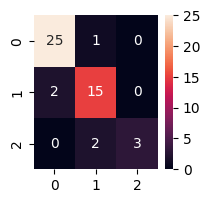

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        34
         1.0       0.90      0.90      0.90        31
         2.0       1.00      0.57      0.73         7

    accuracy                           0.92        72
   macro avg       0.94      0.82      0.86        72
weighted avg       0.92      0.92      0.91        72

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94        26
         1.0       0.83      0.88      0.86        17
         2.0       1.00      0.60      0.75         5

    accuracy                           0.90        48
   macro avg       0.92      0.81      0.85        48
weighted avg       0.90      0.90      0.89        48



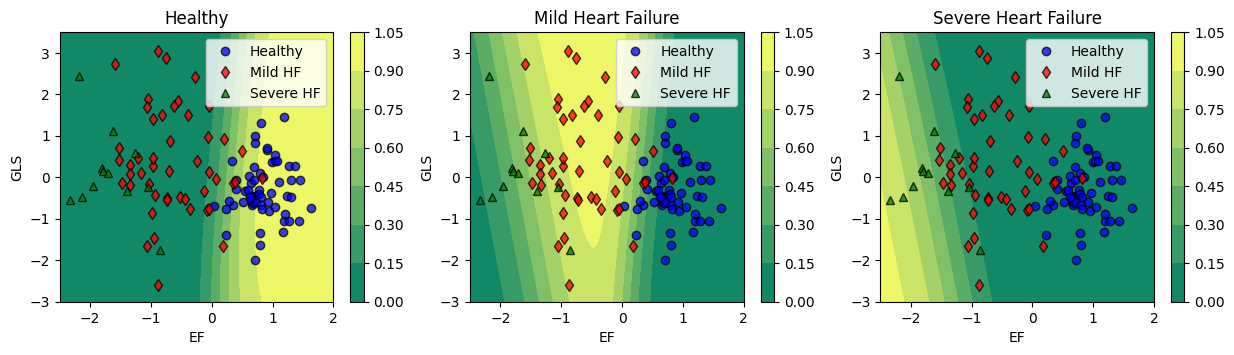

In [13]:
svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(X_train, y_train)
EvaluateModel(svc_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(15,3.5))
classes = ['Healthy', 'Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1, 3, i+1)
    PlotProbabilities(svc_model, X, y, label=i)
    plt.title(classes[i])

## Support Vector Classifier with Kernel Trick


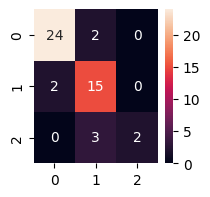

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        34
         1.0       0.90      0.90      0.90        31
         2.0       1.00      0.57      0.73         7

    accuracy                           0.92        72
   macro avg       0.94      0.82      0.86        72
weighted avg       0.92      0.92      0.91        72

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        26
         1.0       0.75      0.88      0.81        17
         2.0       1.00      0.40      0.57         5

    accuracy                           0.85        48
   macro avg       0.89      0.74      0.77        48
weighted avg       0.87      0.85      0.85        48



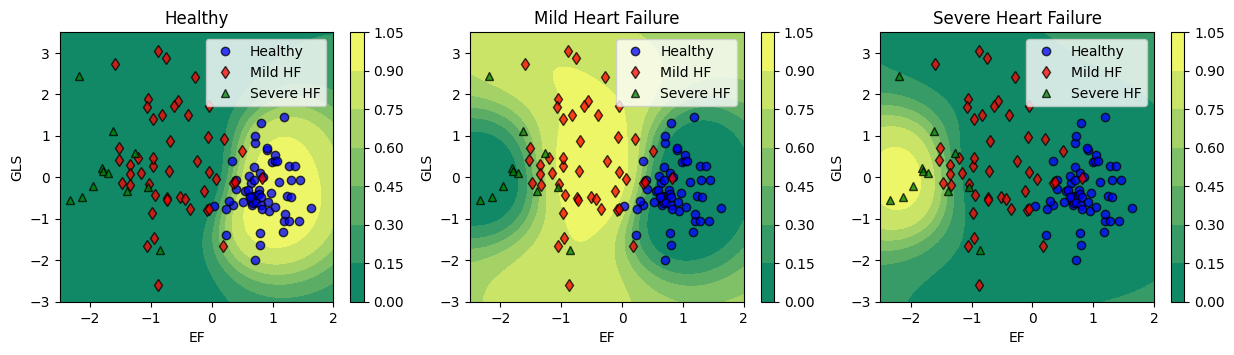

In [14]:
kernelsvc_model = SVC(kernel='rbf', probability=True)
kernelsvc_model.fit(X_train, y_train)
EvaluateModel(kernelsvc_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(15,3.5))
classes = ['Healthy', 'Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1, 3, i+1)
    PlotProbabilities(kernelsvc_model, X, y, label=i)
    plt.title(classes[i])

## Decision Tree


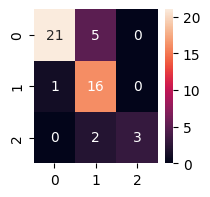

Classification report for training set:
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        34
         1.0       0.86      1.00      0.93        31
         2.0       1.00      0.71      0.83         7

    accuracy                           0.93        72
   macro avg       0.95      0.88      0.90        72
weighted avg       0.94      0.93      0.93        72

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.88        26
         1.0       0.70      0.94      0.80        17
         2.0       1.00      0.60      0.75         5

    accuracy                           0.83        48
   macro avg       0.88      0.78      0.81        48
weighted avg       0.87      0.83      0.84        48



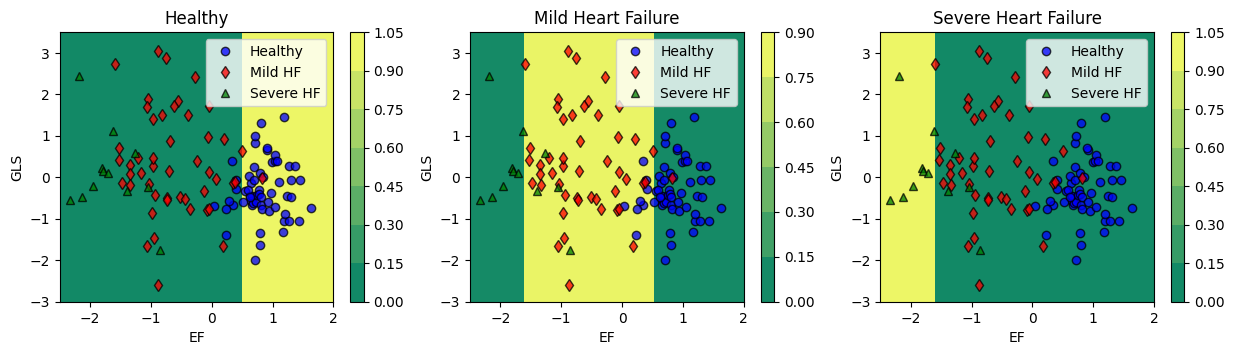

In [15]:
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train, y_train)
EvaluateModel(tree_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(15,3.5))
classes = ['Healthy', 'Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1, 3, i+1)
    PlotProbabilities(tree_model, X, y, label=i)
    plt.title(classes[i])

## Random Forest


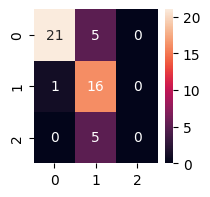

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96        34
         1.0       0.78      0.94      0.85        31
         2.0       0.00      0.00      0.00         7

    accuracy                           0.86        72
   macro avg       0.58      0.64      0.60        72
weighted avg       0.78      0.86      0.82        72

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.88        26
         1.0       0.62      0.94      0.74        17
         2.0       0.00      0.00      0.00         5

    accuracy                           0.77        48
   macro avg       0.52      0.58      0.54        48
weighted avg       0.73      0.77      0.74        48



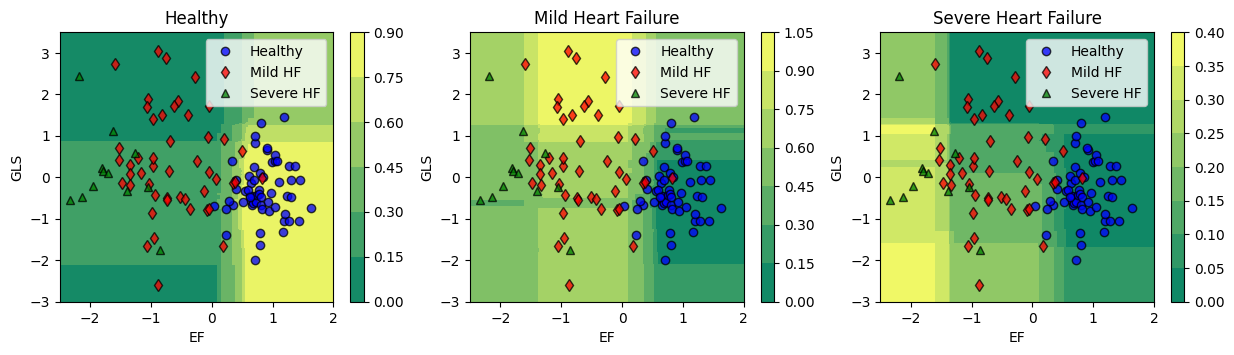

In [16]:
forest_model = RandomForestClassifier(n_estimators=100, max_depth=2)
forest_model.fit(X_train, y_train)
EvaluateModel(forest_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(15,3.5))
classes = ['Healthy', 'Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1, 3, i+1)
    PlotProbabilities(forest_model, X, y, label=i)
    plt.title(classes[i])

## Exercise 3: Balanced multi-label classification (optional)

One way to deal with class imbalance is to increase the weight of the samples of smaller classes in the classification loss. For `LogisticRegression` this can be done by setting `class_weight='balanced'`, which will weight the sample inversly to the class size, this giving equal importance to each class irrespective of its size. 

In this exercise you will fit the logistic regression with class weighting and analyse the performance of the balanced model.

### Task 1: Fit and plot the balanced model

Fit the logistic regression with `class_weight='balanced'` and plot the classification boundaries/labels.

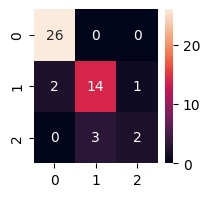

Classification report for training set:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        34
         1.0       0.96      0.77      0.86        31
         2.0       0.67      0.86      0.75         7

    accuracy                           0.89        72
   macro avg       0.84      0.88      0.85        72
weighted avg       0.90      0.89      0.89        72

Classfication report for test set:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        26
         1.0       0.82      0.82      0.82        17
         2.0       0.67      0.40      0.50         5

    accuracy                           0.88        48
   macro avg       0.81      0.74      0.76        48
weighted avg       0.86      0.88      0.87        48



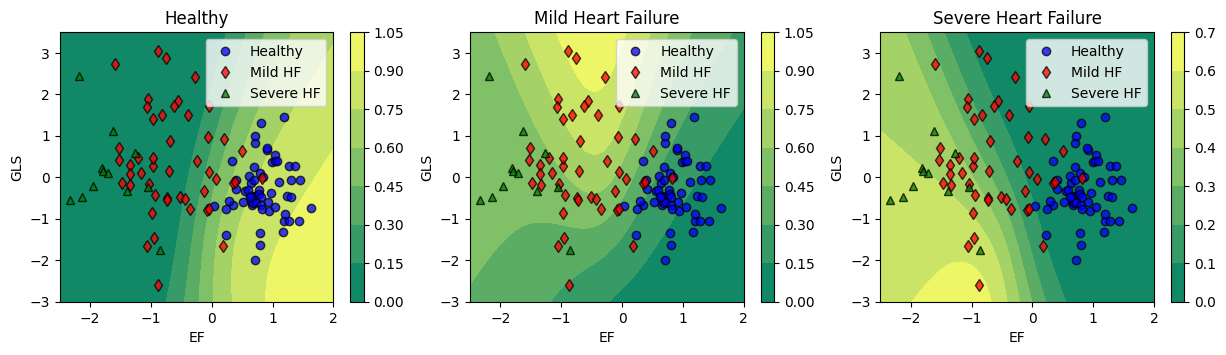

In [17]:
logreg_model2 = LogisticRegression(class_weight='balanced', multi_class='ovr')
logreg_model2.fit(X_train, y_train)
EvaluateModel(logreg_model2, X_train, X_test, y_train, y_test)
plt.figure(figsize=(15,3.5))
classes = ['Healthy', 'Mild Heart Failure', 'Severe Heart Failure']
for i in range(3):
    plt.subplot(1, 3, i+1)
    PlotProbabilities(logreg_model2, X, y, label=i)
    plt.title(classes[i])